# Density Estimation with Neural ODEs

`torchdyn` allows for easy implementation of density estimation models. Continuous normalizing flows (CNFs) sidestep architectural restrictions of discrete flows, necessary to preserve tractability of the log-determinant of the Jacobian. This is achieved by leveraging the computationally [cheaper divergence](https://arxiv.org/abs/1810.01367) obtainable by a change of variable in continuous-depth. The flow is normalized by the instantaneous divergence to preserve the integral norm of the density throughout the dynamics. We refer to this excellent tutorial and survey for an in-depth introduction.

This notebooks shows a regular continuous normalizing flow [CNF](https://arxiv.org/abs/1806.07366) and its successor [FFJORD](https://arxiv.org/abs/1810.01367), implemented with a few lines of `torchdyn`.

Following tutorials will discuss regularization strategies to speed up CNF training, as those discussed for example in [this paper](https://arxiv.org/abs/2002.02798).

### Normalizing-flows

Given a data vector $\mathbf{x}$ distributed according to an unknown joint distribution $\mathbf{x}\sim p(\mathbf{x})$, we aim to recover $p(\mathbf{x})$.

In [1]:
import sys

sys.path.append('..')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical

**Data**: we use a standard N-gaussians dataset. The data is z-normalized for easier training.

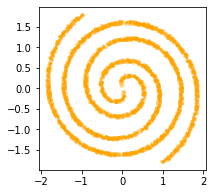

In [2]:
data = ToyDataset()
n_samples = 2056

X, yn = data.generate(n_samples, 'spirals', noise=0.5)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='orange', alpha=0.3, s=4)

In [3]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=256, shuffle=True) 

## Continuous Normalizing Flow

First, we show a minimal implementation of a regular *continuous normalizing flow* (`CNF`). This exercise showcases the flexibility of `torchdyn`: a `CNF` can be defined as nothing more than a wrap for any `DEFunc`, handling the additional dimension dedicated to the divergence propagation during forward and backward dynamics. This approach is natural as it allows the utilization of any `DEFunc` variant to handle the data--dynamics.

In [4]:
# class CNF(nn.Module):
#     def __init__(self, net):
#         super().__init__()
#         self.net = net

#     def forward(self, x):   
#         with torch.set_grad_enabled(True):
#             x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x) # first dimension reserved to divergence propagation
#             x_out = self.net(x_in) # the neural network will handle the data-dynamics here
#             trJ = self.jacobian_trace(x_out, x_in)
#         out = torch.cat([-trJ[:, None], x_out], 1) + 0*x # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph
#         return out
    
#     def jacobian_trace(self, x_out, x_in):
#         trJ = 0.
#         # exact trace computation requires O(d) calls to autograd, where d is the data-dim
#         for i in range(x_in.shape[1]):
#             trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]    
#         return trJ

The above template also lends itself to a simple `FFJORD` implementation by a simple change of `jacobian_trace`

A "correct" solution of the dynamics ODE is necessary for the instantaneous change of variables of $log p(x)$ to hold, suggesting the use of adaptive-step solvers such as *dopri5*. However, fixed-step solvers with a fine-enough grid `s_span` can be successfully employed as well:

In [19]:
f = nn.Sequential(
        nn.Linear(2, 128),
        nn.Softplus(),
        nn.Linear(128, 128),
        nn.Softplus(),
        nn.Linear(128, 2)
    )

# f2 = nn.Sequential(
#         nn.Linear(2, 512),
#         nn.ELU(),
#         nn.Linear(512, 2)
#     )

# cnf wraps the net as with other energy models
noise_dist = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

cnf = nn.Sequential(CNF(f, trace_estimator=hutch_trace, noise_dist=noise_dist))

nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), atol=1e-5, rtol=1e-5, sensitivity='adjoint')

model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

Augmenter takes care of setting up the additional scalar dimension for the divergence dynamics.
The `DEFunc` wrapper will ensure compatibility of depth-concatenation and data-control with the divergence dimension
Utilizing additional augmented dimensions is also compatible, as only the first will be used for the jacobian trace.

In [20]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

CNFs require the specification of a prior distribution in latent space. We use a simple isotropic `Multivariate Normal`:

In [22]:
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

Standard Learner. However, the `loss` calculation is different than usual. As stated in the intro, we maximize the log-likelihood of the data directly (and not a surrogate such as with VAEs). This is possible due to the invertibily of normalizing flows.

In [23]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1 ; x, _ = batch     
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] 
        loss = -torch.mean(logprob)
        
        if self.iters % 10 == 0: 
            print(f'Loss: {loss}, Iteration: {self.iters}, Epoch: {self.iters // self.loader_l}, NFE: {nde.nfe}')
        
        logs = {'train_loss': loss}
        nde.nfe = 0
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-5)

    def train_dataloader(self):
        self.loader_l = len(trainloader)
        return trainloader

In [24]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=500, max_epochs=550, log_save_interval=100)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 17 K  
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Loss: 2.85268497467041, Iteration: 10, Epoch: 0, NFE: 40
Loss: 2.7825632095336914, Iteration: 20, Epoch: 1, NFE: 40
Loss: 2.8990039825439453, Iteration: 30, Epoch: 1, NFE: 40
Loss: 2.8541040420532227, Iteration: 40, Epoch: 2, NFE: 40
Loss: 2.858147144317627, Iteration: 50, Epoch: 2, NFE: 40
Loss: 2.8197226524353027, Iteration: 60, Epoch: 3, NFE: 40
Loss: 2.8174691200256348, Iteration: 70, Epoch: 4, NFE: 40
Loss: 2.8663992881774902, Iteration: 80, Epoch: 4, NFE: 40
Loss: 2.814267158508301, Iteration: 90, Epoch: 5, NFE: 40
Loss: 2.801055431365967, Iteration: 100, Epoch: 5, NFE: 40
Loss: 2.840203285217285, Iteration: 110, Epoch: 6, NFE: 40
Loss: 2.8122718334198, Iteration: 120, Epoch: 7, NFE: 40
Loss: 2.8645663261413574, Iteration: 130, Epoch: 7, NFE: 40
Loss: 2.8169240951538086, Iteration: 140, Epoch: 8, NFE: 40
Loss: 2.796091079711914, Iteration: 150, Epoch: 8, NFE: 40
Loss: 2.8357138633728027, Iteration: 160, Epoch: 9, NFE: 40
Loss: 2.66856050491333, Iteration: 170, Epoch: 10, NFE: 40


Sampling from CNFs is easy: we query the prior normal and then pass them through the reversed CNF flow. To reverse the flow, we flip `s_span`:

In [25]:
def make_img(i):
    sample = prior.sample(torch.Size([2056]))
    # integrating from 1 to 0, 8 steps of rk4
    model[1].s_span = torch.linspace(1, 0, 2)
    new_x = model(sample).cpu().detach()
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(new_x[:,0], new_x[:,1], s=0.3, c='blue')
    #plt.scatter(boh[:,0], boh[:,1], s=0.3, c='black')

    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=0.3, c='red')
    plt.savefig(f'debug_img/{i}')

In [26]:
sample = prior.sample(torch.Size([2056]))
# integrating from 1 to 0, 8 steps of rk4
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

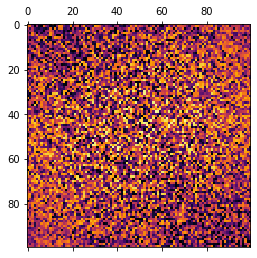

In [27]:
npts = 100
side = np.linspace(-1, 1, npts)
xx, yy = np.meshgrid(side, side)
memory= 100

x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
x = torch.from_numpy(x).type(torch.float32).to(device)

z, delta_logp = [], []
inds = torch.arange(0, x.shape[0]).to(torch.int64)
for ii in torch.split(inds, int(memory**2)):
    model[1].s_span = torch.linspace(0, 1, 2)
    z_full = model(x[ii]).cpu().detach()
    z_, delta_logp_ = z_full[:, 1:], z_full[:, 0]
    z.append(z_)
    delta_logp.append(delta_logp_)
z = torch.cat(z, 0)
delta_logp = torch.cat(delta_logp, 0)

#prior = prior.cpu()
logpz = prior.log_prob(z.cuda()).cpu()# logp(z)
logpx = logpz - delta_logp
px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
plt.matshow(px, cmap='inferno')

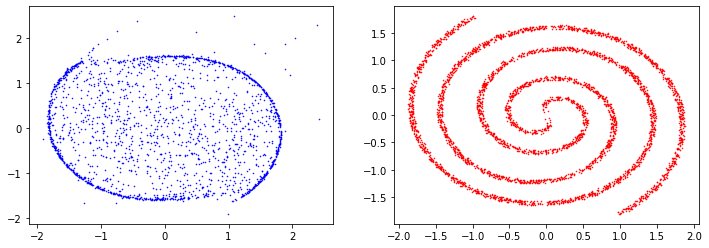

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=0.3, c='blue')
#plt.scatter(boh[:,0], boh[:,1], s=0.3, c='black')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=0.3, c='red')

We plot the flows from prior to data distribution:

In [63]:
traj = model[1].trajectory(Augmenter(1, 1)(sample.cuda()), s_span=torch.linspace(1,0,10)).detach().cpu() ; sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

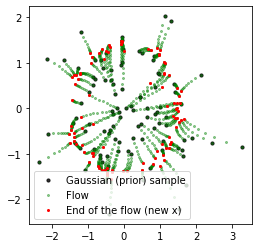

In [64]:
plt.figure(figsize=(4,4))
plt.scatter(sample[:100,0], sample[:100,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:100,0], traj[:,:100,1], s=4, alpha=0.4, c='g')
plt.scatter(traj[-1,:100,0], traj[-1,:100,1], s=4, alpha=1, c='red')
plt.legend(['Gaussian (prior) sample', 'Flow', 'End of the flow (new x)'])

## FFJORD

Free-form Jacobian of Reversible Dynamics

Great! You've seen how to train continuous normalizing flows in `torchdyn`. Next, we will tackle some recent advances on regularization tricks to speed training, as well as new variants.